In [31]:
import scanpy as sc
import numpy as np
import pandas as pd
import phate 
import scipy as sp
from scipy.spatial.distance import pdist, squareform
from data import train_valid_loader_from_pc
from model import AEDist
import torch
from torch import nn
from transformations import LogTransform, NonTransform, StandardScaler, \
    MinMaxScaler, PowerTransformer, KernelTransform

from src.fim_noemb import FIM
from torchdyn.core import NeuralODE

from src.fim_noemb import FIM_torch
from src.fim_noemb import FIM_cpu
from typing import Optional, List
from tqdm import tqdm

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from torch.utils.data import Dataset

import sys 
sys.path.insert(0, "/home/icb/alessandro.palma/environment/flatvi_baselines/phate_fim/src")
from src.models.lit_encoder import LitAutoencoder

In [2]:
class torch_dataset(Dataset):
    def __init__(self, X, Y) -> None:
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        target = self.Y[index, :]
        sample = self.X[index, :]
        return sample, target

In [3]:
adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/scCFM/project_dir/data/pancreas/processed/pancreas.h5ad")
X_expression = np.array(adata.X.copy().todense())

In [4]:
phate_op = phate.PHATE()
phate_coords = phate_op.fit_transform(X_expression)

Calculating PHATE...
  Running PHATE on 20519 observations and 2000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.25 seconds.
    Calculating KNN search...
    Calculated KNN search in 18.53 seconds.
    Calculating affinities...
    Calculated affinities in 2.94 seconds.
  Calculated graph and diffusion operator in 23.76 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.35 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.96 seconds.
  Calculated landmark operator in 5.20 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 1.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.25 seconds.
Calculated PHATE in 34.04 seconds.


In [5]:
phate_coords = sp.stats.zscore(phate_coords) 

In [6]:
X_expression = torch.from_numpy(X_expression)
phate_coords = torch.from_numpy(phate_coords)

In [10]:
# Callable dict 
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Hparams 
args = Args(
    run_name=None,
    dataset="tree",
    n_obs=1600,
    n_dim=2000,
    batch_size=256,
    knn=5,
    max_epochs=100,
    wandb=False,
    encoder_layer=[256, 100, 10],
    decoder_layer=[10, 100, 256],
    activation="ReLU",
    lr=0.0001,
    kernel_type="phate",
    loss_emb=False,
    loss_dist=True,
    loss_rec=True,
    scale=0.0005,
    inference=False,
    inference_obs=1600
)
dict_args = vars(args)

In [11]:
emb_dim = args.encoder_layer[-1]
model = LitAutoencoder(input_dim=args.n_dim, emb_dim=emb_dim, **dict_args)

[Linear(in_features=2000, out_features=256, bias=True), ReLU(), Linear(in_features=256, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=10, bias=True), Softmax(dim=1)]


In [12]:
model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scCFM/project_dir/baselines/neuralfim/model_ckpt.pt"))

<All keys matched successfully>

In [13]:
with torch.no_grad():
    z = model.encode(X_expression)
    X_recon = model.decode(z)

Check encodings 

In [14]:
recon_adata_z = sc.AnnData(X=z.numpy(), obs=adata.obs.copy())

In [15]:
sc.tl.pca(recon_adata_z)
sc.pp.neighbors(recon_adata_z)
sc.tl.umap(recon_adata_z)

/home/icb/alessandro.palma/miniconda3/envs/flatvi_baselines_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/flatvi_baselines_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


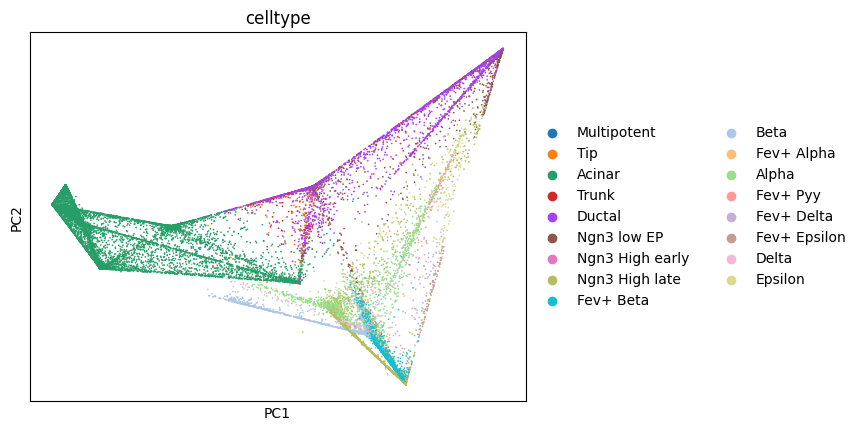

In [16]:
sc.pl.pca(recon_adata_z, color="celltype")

Check reconstruction

In [17]:
recon_adata = sc.AnnData(X=X_recon.numpy(), obs=adata.obs.copy())

In [18]:
sc.tl.pca(recon_adata)
sc.pp.neighbors(recon_adata)
sc.tl.umap(recon_adata)

/home/icb/alessandro.palma/miniconda3/envs/flatvi_baselines_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/flatvi_baselines_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


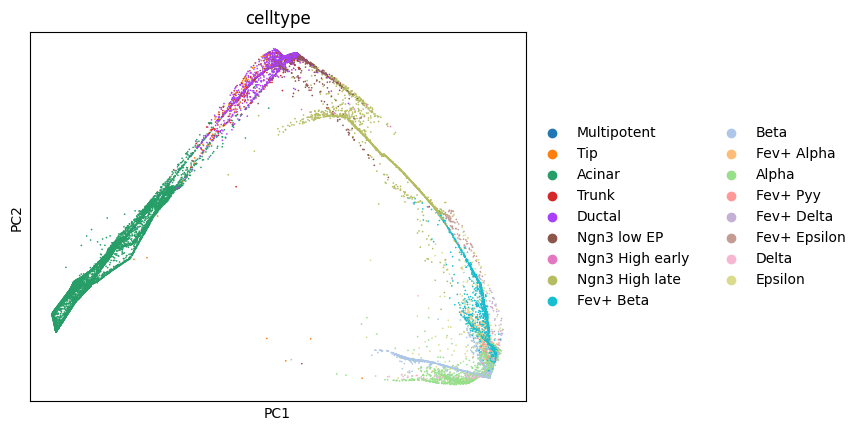

In [19]:
sc.pl.pca(recon_adata, color="celltype")

Check reconstruction compared to real 

In [25]:
recon_adata = sc.AnnData(X=np.concatenate([X_recon.numpy(), X_expression]))
obs = {"Dataset type": ["Real" for _ in range(X_recon.shape[0])] +
                       ["Generated" for _ in range(X_expression.shape[0])]}

In [26]:
sc.tl.pca(recon_adata)
sc.pp.neighbors(recon_adata)
sc.tl.umap(recon_adata)

In [33]:
recon_adata.obs = pd.DataFrame(obs)

/home/icb/alessandro.palma/miniconda3/envs/flatvi_baselines_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/flatvi_baselines_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


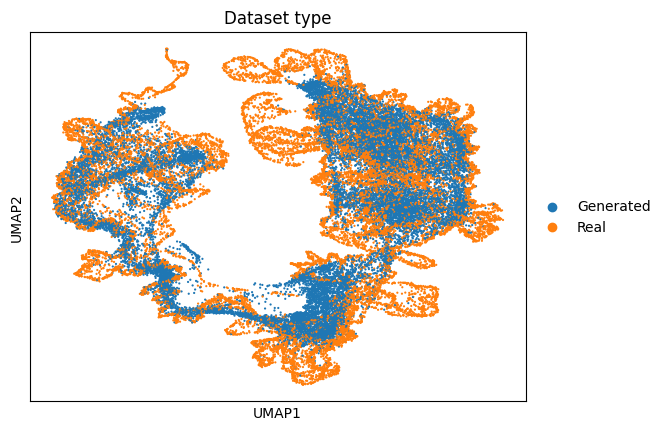

In [38]:
sc.pl.umap(recon_adata[np.random.permutation(range(recon_adata.shape[0]))], color="Dataset type", s=10)

In [43]:
9.99*60

599.4

In [45]:
(67/100)*60

40.2

In [ ]:
(67/100)*60

In [46]:
(59*60)/500

7.08

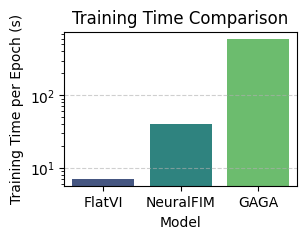

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
training_times = {"Model": ["FlatVI", "NeuralFIM", "GAGA"],
                  "Times (s)": [7.08, 40.2, 599.4]}

df = pd.DataFrame(training_times)

# Create a small bar plot
plt.figure(figsize=(3, 2))  # Small figure size
sns.barplot(data=df, x="Model", y="Times (s)", palette="viridis")

# Formatting
plt.yscale("log")  # Log scale for better comparison
plt.ylabel("Training Time per Epoch (s)")
plt.title("Training Time Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()
